In [1]:
import habitat

/home/green-tea/miniconda3/envs/habitat/lib/python3.6/site-packages/numba-0.46.0-py3.6-linux-x86_64.egg/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
import coco

/home/green-tea/miniconda3/envs/habitat/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/green-tea/miniconda3/envs/habitat/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/green-tea/miniconda3/envs/habitat/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/green-tea/miniconda3/envs

In [3]:
from mrcnn import utils
import os
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
from mrcnn import visualize
import mrcnn.model as modellib

In [4]:
config = habitat.get_config("/home/green-tea/all_projects/habitat/segmentation/configs/challenge_objectnav2020.local.rgbd.yaml")

In [5]:
config.defrost()

config.DATASET.DATA_PATH = "/home/green-tea/all_stash/matterport3D/data/val_mini.json.gz"
config.DATASET.SCENES_DIR = "/home/green-tea/all_stash/matterport3D/data4/v1/tasks"

config.SIMULATOR.AGENT_0.SENSORS.append('SEMANTIC_SENSOR')

config.freeze()

In [6]:
env = habitat.Env(config)

2020-04-08 18:26:35,761 Initializing dataset ObjectNav-v1
2020-04-08 18:26:35,865 initializing sim Sim-v0
I0408 18:26:41.089089 6018 simulator.py:143] Loaded navmesh /home/green-tea/all_stash/matterport3D/data4/v1/tasks/mp3d/x8F5xyUWy9e/x8F5xyUWy9e.navmesh
I0408 18:26:41.089840 6018 simulator.py:155] Recomputing navmesh for agent's height 0.88 and radius 0.18.
2020-04-08 18:26:41,190 Initializing task ObjectNav-v1


In [7]:
scene = env.sim.semantic_annotations()
index_to_title_map = {obj.category.index(): obj.category.name() for obj in scene.objects }
index_to_title_map[-1] = 'nope'
print(index_to_title_map)

{1: 'wall', 40: 'misc', 16: 'stairs', 4: 'door', 2: 'floor', 39: 'objects', 17: 'ceiling', 0: 'void', 14: 'plant', 24: 'column', -1: 'nope', 5: 'table', 21: 'mirror', 15: 'sink', 7: 'cabinet', 28: 'lighting', 34: 'seating', 20: 'towel', 12: 'curtain', 9: 'window', 23: 'shower', 38: 'clothes', 11: 'bed', 35: 'board_panel', 37: 'appliances', 31: 'shelving', 26: 'counter', 22: 'tv_monitor', 3: 'chair'}


In [8]:
num_classes = len(list(index_to_title_map.keys()))

In [9]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    # Give the configuration a recognizable name
    NAME = "habitat"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = num_classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 480
    IMAGE_MAX_DIM = 640

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 64, 128, 256, 480)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
#     TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                41
IMAGE_MIN_DIM                  480
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [10]:
scene = env.sim.semantic_annotations()
instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
mapper = np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])

index_to_title_map = {obj.category.index(): obj.category.name() for obj in scene.objects }

In [11]:
print(np.array(list(index_to_title_map.keys())))

[ 1 40 16  4  2 39 17  0 14 24 -1  5 21 15  7 28 34 20 12  9 23 38 11 35
 37 31 26 22  3]


In [12]:
model_classes = []
model_mapper = {}
to_model_mapper = {}

index = 0
for key in index_to_title_map:
    model_classes.append(index_to_title_map[key])
    model_mapper[index] = key
    to_model_mapper[key] = index
    index += 1

In [13]:
class HabitatDataset(utils.Dataset):
    
    def __init__(self, path, data=None):
        self.path = path
        
        scene = env.sim.semantic_annotations()
        index_to_title_map = {obj.category.index() + 1: obj.category.name() for obj in scene.objects }
        index_to_title_map[-1] = 'nope'
        
        self.class_names = model_classes
        self.source_class_ids = {'habitat': np.array(range(len(self.class_names)))}
        
        self.num_classes = len(self.class_names)
        
        if not(data is None):
            self.X = data['X']
            self.Y = data['Y']
            
            self._image_ids = range(len(self.X))
            
            self.image_info = []
            
            for index in range(len(self.X)):
                self.image_info.append({
                    'id': index,
                    'source': 'habitat',
                    'path': None,
                    'width': 480,
                    'height': 640,
                })
    
    def prepare_dataset(self):
        x_path = self.path + '/X'
        y_path = self.path + '/Y'
        
        x_images = {}
        for root, dirs, files in os.walk(x_path, topdown=False):
            for file in files:
                
                img = image.imread(root + "/" + file)
            
                x_images[file[:-4]] = (img * 256).astype('int')
                
        y_images = {}
        y_classes = {}
        
        for root, dirs, files in os.walk(y_path, topdown=False):
            if len(dirs) > 0:
                continue
                
            title = root[root.rfind("/") + 1:]
            y_images[title] = []     
            y_classes[title] = []
            
            for file in files:
                img = image.imread(root + "/" + file)
                
                y_images[title].append(img)
                
                class_name = mapper[int(file[:-4])]
                y_classes[title].append(class_name)
                
        X = []
        Y = []
        Y_classes = []
        
        for key in x_images:
            if key not in y_images:
                print('error ' + key);
                continue
            
            X.append(x_images[key])
            
            class_count = len(y_images[key])
            y_images[key] = self.__reshape_mask(np.array(y_images[key]))
            
            Y.append((y_images[key], self.__convert_class_to_id(y_classes[key])))
        
        print('prepared ' + str(len(X)) + " images")
        
        self.X = np.array(X)
        self.Y = np.array(Y)
        
        self._image_ids = range(len(self.X))
        

    def load_image(self, image_id):
        return self.X[image_id]
        
    def load_mask(self, image_id):
        return self.Y[image_id]
    
    def __convert_class_to_id(self, classes):
        response = []
        
        for item in classes:
            response.append(to_model_mapper[item])

        return np.array(response)
    
    def __reshape_mask(self, a):
        b = np.zeros([a.shape[1], a.shape[2], a.shape[0]])

        for i in range(len(a)):
            b[:, :, i] = a[i, :, :]
                    
        return b
    
    def split_on_train_and_val(self, train_count, val_count):
        
        ids = np.array(range(len(self.X)))
        np.random.shuffle(ids)
        
        train_data = {
            'X': self.X[ids[:train_count]],
            'Y': self.Y[ids[:train_count]]
        }
        
        val_data = {
            'X': self.X[ids[train_count : train_count + val_count]],
            'Y': self.Y[ids[train_count : train_count + val_count]],
        }
        
        return (HabitatDataset(self.path, train_data), HabitatDataset(self.path, val_data))

In [14]:
dataset = HabitatDataset('/home/green-tea/all_projects/habitat/mask-r-cnn')

In [15]:
dataset.prepare_dataset()

prepared 52 images


In [16]:
dataset

In [17]:
(train_dataset, test_dataset) = dataset.split_on_train_and_val(48, 16)

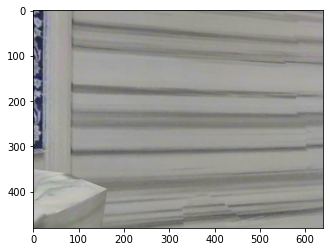

In [18]:
img = train_dataset.load_image(0)

plt.imshow(img)

ceiling


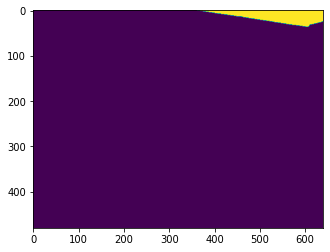

table


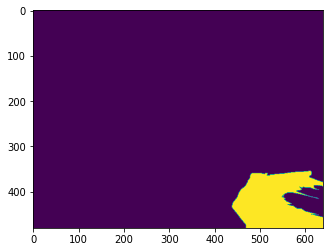

wall


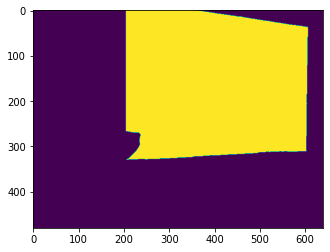

wall


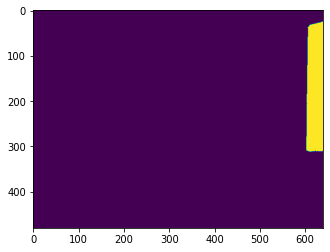

floor


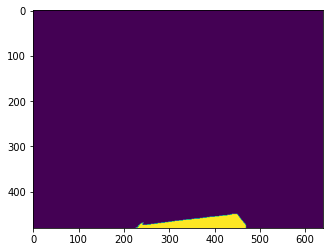

sink


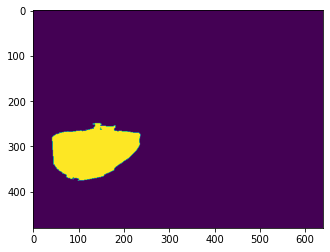

towel


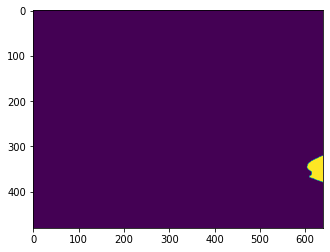

objects


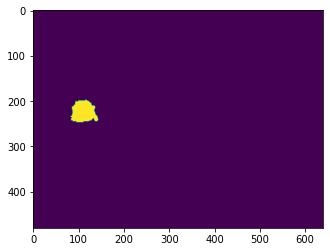

towel


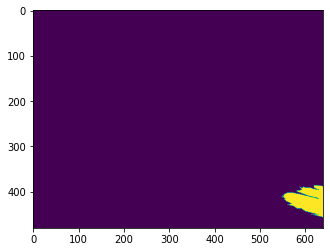

wall


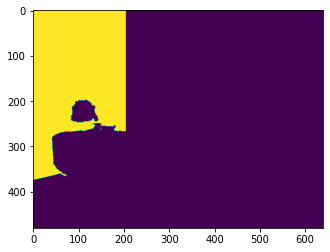

seating


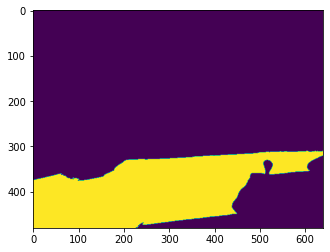

lighting


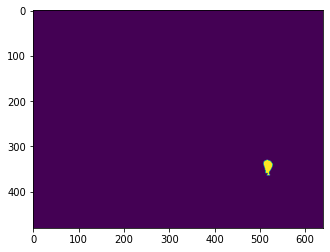

In [34]:
masks, class_ids = train_dataset.load_mask(0)

for i in range(masks.shape[2]):
    print(dataset.class_names[class_ids[i]])
    plt.imshow(masks[:, :, i])
    plt.show()

In [53]:
print(masks[1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{2: 'wall', 41: 'misc', 17: 'stairs', 5: 'door', 3: 'floor', 40: 'objects', 18: 'ceiling', 1: 'void', 15: 'plant', 25: 'column', 0: '', 6: 'table', 22: 'mirror', 16: 'sink', 8: 'cabinet', 29: 'lighting', 35: 'seating', 21: 'towel', 13: 'curtain', 10: 'window', 24: 'shower', 39: 'clothes', 12: 'bed', 36: 'board_panel', 38: 'appliances', 32: 'shelving', 27: 'counter', 23: 'tv_monitor', 4: 'chair', -1: 'nope'}
(480, 640, 19)
[2, 10, 18, 41, 10, 2, 5, 35, 3, 16, 41, 41, 2, 41, 5, 3, 35, 2, 18]


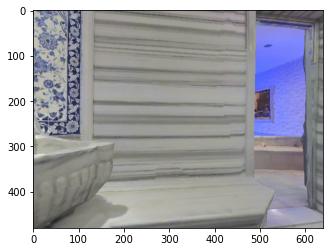

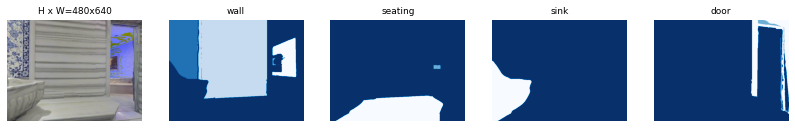

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(480, 640, 21)
[0, 2, 41, 18, 41, 4, 5, 4, 41, 41, 2, 2, 41, 41, 5, 2, 3, 35, 18, 10, 17]


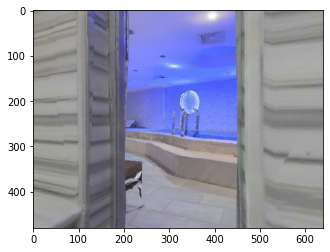

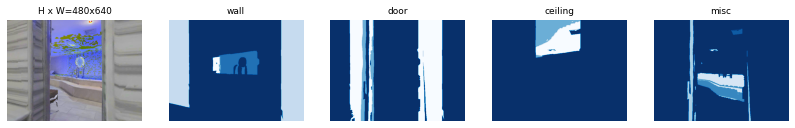

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(480, 640, 23)
[10, 10, 18, 18, 41, 10, 2, 5, 35, 2, 3, 16, 41, 40, 2, 41, 2, 41, 5, 3, 35, 2, 18]


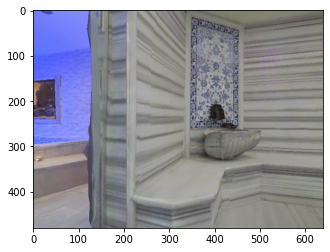

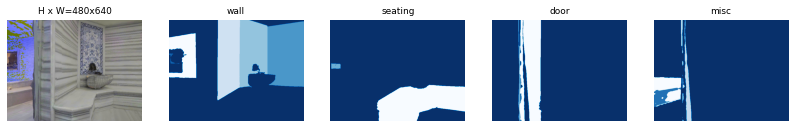

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(480, 640, 15)
[0, 2, 41, 41, 2, 41, 10, 40, 2, 41, 5, 3, 35, 2, 18]


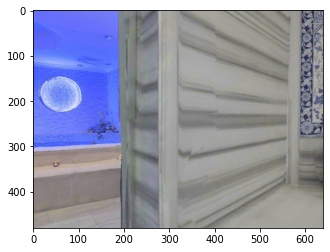

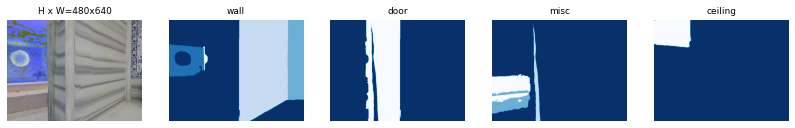

In [54]:
image_ids = np.random.choice(range(48), 4)
print(dataset.class_names)

for image_id in image_ids:

    img = dataset.load_image(image_id)
    (masks, class_ids) = dataset.load_mask(image_id)

    print(masks.shape)
    print(class_ids)

    plt.imshow(img)
    plt.show()

    visualize.display_top_masks(img, masks, class_ids, dataset.class_names)

In [19]:
MODEL_DIR = "/home/green-tea/all_projects/mask-R-CNN/v2/Mask_RCNN/logs"

model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [20]:
COCO_MODEL_PATH = "/home/green-tea/all_projects/mask-R-CNN/v2/Mask_RCNN/mask_rcnn_coco.h5"

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
model.train(train_dataset, test_dataset, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/green-tea/all_projects/mask-R-CNN/v2/Mask_RCNN/logs/habitat20200408T1827/mask_rcnn_habitat_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4  

/home/green-tea/miniconda3/envs/habitat/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/green-tea/miniconda3/envs/habitat/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


Process Process-18:
Process Process-12:
Process Process-15:
Process Process-16:
Process Process-13:
Process Process-14:
Traceback (most recent call last):
Process Process-17:
Traceback (most recent call last):
Process Process-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-11:
  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/green-tea/miniconda

  File "/home/green-tea/all_projects/habitat/mask-r-cnn/mrcnn/utils.py", line 72, in compute_iou
    y2 = np.minimum(box[2], boxes[:, 2])
  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/site-packages/keras/utils/data_utils.py", line 654, in _data_generator_task
    generator_output = next(self._generator)
KeyboardInterrupt
  File "/home/green-tea/all_projects/habitat/mask-r-cnn/mrcnn/utils.py", line 73, in compute_iou
    x1 = np.maximum(box[1], boxes[:, 1])
KeyboardInterrupt
  File "/home/green-tea/all_projects/habitat/mask-r-cnn/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/green-tea/all_projects/habitat/mask-r-cnn/mrcnn/utils.py", line 75, in compute_iou
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
Process Process-3:
Process Process-5:
Process Process-7:
Process Process-4:
Process Process-2:
Process Process-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

Traceback (most recent call last):
  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "<__array_function__ internals>", line 6, in inv
  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/multiprocessing/managers.py", line 809, in _decref
    conn = _Client(token.address, authkey=authkey)
  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/green-tea/.

  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
Process Process-8:
Traceback (most recent call last):
  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/green-tea/miniconda3/envs/habitat/lib/python3.6/site-packages/keras/utils/data_utils.py", line 654, in _data_generator_task
    generator_output = next(self._generator)
  F

In [ ]:
model.train(train_dataset, test_dataset, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")